# 2.6 SubGraph: LangGraph Agent를 Node로 활용하는 방법

- [Adaptive-RAG: Learning to Adapt Retrieval-Augmented Large Language Models through Question Complexity](https://arxiv.org/abs/2403.14403)논문을 구현합니다
- LangGraph 공식문서의 흐름을 따라갑니다
    - 공식문서의 흐름은 간소화된 버전입니다
    - 실제 논문과 유사한 구현은 3.3강을 참고해주세요

![adaptive-rag](https://i.imgur.com/tbICSxY.png)

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

### 기존 구현 부분

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list # document 또는 web search 결과
    answer: str
    
graph_builder = StateGraph(AgentState)

In [3]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 웹 검색을 수행합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 웹 검색 결과가 추가된 state를 반환합니다.
    """
    query = state['query']
    results = tavily_search_tool.invoke(query)

    return {'context': results}

In [4]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# LangChain 허브에서 프롬프트를 가져옵니다
generate_prompt = hub.pull("rlm/rag-prompt")
# OpenAI의 GPT-4o 모델을 사용합니다
generate_llm = ChatOpenAI(model="gpt-4o")

def web_generate(state: AgentState) -> AgentState:
    """
    주어진 문맥과 질문을 기반으로 답변을 생성합니다.

    Args:
        state (AgentState): 문맥과 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 답변을 포함한 state를 반환합니다.
    """
    # state에서 문맥과 질문을 추출합니다
    context = state['context']
    query = state['query']
    
    # 프롬프트와 모델, 출력 파서를 연결하여 체인을 생성합니다
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    
    # 체인을 사용하여 답변을 생성합니다
    response = rag_chain.invoke({'question': query, 'context': context})
    
    # 생성된 답변을 'answer'로 반환합니다
    return {'answer': response}

### 추가로 구현하는 부분

간단한 질문에 답변을 하는 경우 작은 모델을 활용해서 비용을 저감하고, 답변 생성 속도를 향상시킬 수 있음

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# OpenAI의 GPT-4o-mini 모델을 사용합니다
basic_llm = ChatOpenAI(model="gpt-4o-mini")

def basic_generate(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 기본 답변을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 답변을 포함한 state를 반환합니다.
    """
    # state에서 질문을 추출합니다
    query = state['query']
    
    # 기본 LLM 체인을 생성합니다
    basic_llm_chain = basic_llm | StrOutputParser()
    
    # 체인을 사용하여 답변을 생성합니다
    llm_response = basic_llm_chain.invoke(query)
    
    # 생성된 답변을 'answer'로 반환합니다
    return {'answer': llm_response}

Query Analysis는 라우터와 같은 개념

사용자의 질문이 들어오면 `router` 노드에서 사용자의 질문을 분석해서 적절한 노드로 이동
- 사용자의 질문에 관한 내용이 vector store에 있는 경우 `income_tax_agent` 노드로 이동
- 사용자의 질문이 간단한 경우 `basic_generate` 노드로 이동
- 사용자의 질문이 웹 검색을 통해 답변을 얻을 수 있는 경우 `web_search` 노드로 이동

라우터 출력 선택을 위한 데이터 타입 클래스 정의

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['vector_store', 'llm', 'web_search'] = Field(
        description="The target for the query to answer"
    )

In [7]:
router_system_prompt = """
You are an expert at routing a user's question to 'vector_store', 'llm', or 'web_search'.
'vector_store' contains information about income tax up to December 2024.
if you think the question is simple enough use 'llm'
if you think you need to search the web to answer the question use 'web_search'
"""


router_prompt = ChatPromptTemplate.from_messages([
    ('system', router_system_prompt),
    ('user', '{query}')
])

router_llm = ChatOpenAI(model="gpt-4o-mini")
structured_router_llm = router_llm.with_structured_output(Route)

라우터는 컨디셔널 엣지이다.

In [8]:
def router(state: AgentState) -> Literal['vector_store', 'llm', 'web_search']:
    """
    사용자의 질문에 기반하여 적절한 경로를 결정합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        Literal['vector_store', 'llm', 'web_search']: 질문을 처리하기 위한 적절한 경로를 나타내는 문자열.
    """
    # state에서 질문을 추출합니다
    query = state['query']
    
    # 프롬프트와 구조화된 라우터 LLM을 연결하여 체인을 생성합니다
    router_chain = router_prompt | structured_router_llm 
    
    # 체인을 사용하여 경로를 결정합니다
    route = router_chain.invoke({'query': query})

    # 결정된 경로의 타겟을 반환합니다
    return route.target

### 연결 작업

`node`를 추가하고 `edge`로 연결   
- 앞에서 구현한 그래프를 .py 코드로 변환하여 가져옴

In [9]:
from income_tax_graph import graph as income_tax_subgraph

graph_builder.add_node('income_tax_agent', income_tax_subgraph)
graph_builder.add_node('web_search', web_search)
graph_builder.add_node('web_generate', web_generate)
graph_builder.add_node('basic_generate', basic_generate)

In [10]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START, 
    router,
    {
        'vector_store': 'income_tax_agent',
        'llm': 'basic_generate',
        'web_search': 'web_search'
    }
)

graph_builder.add_edge('web_search', 'web_generate')
graph_builder.add_edge('web_generate', END)
graph_builder.add_edge('basic_generate', END)
graph_builder.add_edge('income_tax_agent', END)

In [11]:
graph = graph_builder.compile()

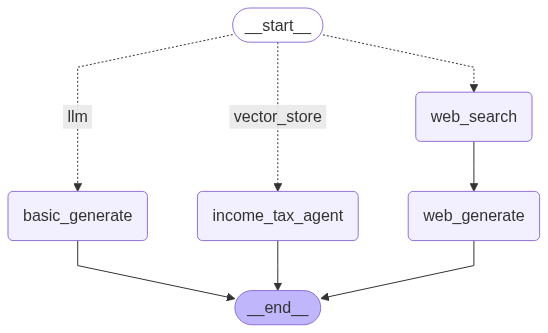

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
initial_state = {'query': '대한민국의 수도는 어디인가요?'}
graph.invoke(initial_state)

{'query': '대한민국의 수도는 어디인가요?', 'answer': '대한민국의 수도는 서울입니다.'}

In [14]:
initial_state = {'query': '연봉 5천만원인 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

{'query': '연봉 5천만원인 거주자의 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='| 종합소득         | 세 율                                  |\n|------------------|---------------------------------------|\n| 1,400만원 이하   | 과세표준의 6세례셋트                      |\n| 1,400만원 초과   | 84만원 + (1,400만원을 초과하는 금액의 15%)  |\n| 5,000만원 이하   | 624만원 + (5,000만원을 초과하는 금액의 24%)  |\n| 8,800만원 이하   | 1,536만원 + (8,800만원을 초과하는 금액의 35%) |\n| 1억5천만원 이하  | 3,706만원 + (1억5천만원을 초과하는 금액의 38%) |\n| 3억 이하         | 9,460만원 + (3억을 초과하는 금액의 40%)      |\n| 5억 이하         | 1억7,406만원 + (5억을 초과하는 금액의 42%)   |\n| 10억 이하        | 3억8,406만원 + (10억을 초과하는 금액의 45%)  |\n법제처 35 \n국가법령정보센터\n소득세법\n② 거주자의 퇴직소득에 대한 소득세는 다음 각 호의 순서에 따라 계산한 금액(이하 "퇴직소득 산출세액"이라 한다)으로 한다.\n<개정> 2013. 1. 1, 2014. 12. 23.\n1. 해당 사업기간의 퇴직소득세표준(제1항의 세율을 적용하여 계산한 금액\n2. 제1호의 금액을 12로 나눈 금액에 근속연수를 곱한 금액\n3. 삭제<2014. 12. 23.>\n[전문개정 2009. 12. 31.]\n제2장 세액공제\n<개정> 2009. 12. 31.\n제56조(배당세액공제)\n① 거주자의 종합소득금액에 제17조제3항 각 호의 부분 단서가 

In [15]:
initial_state = {'query': '역삼 맛집을 추천해주세요'}
graph.invoke(initial_state)

{'query': '역삼 맛집을 추천해주세요',
 'context': [{'url': 'https://sam-repository.tistory.com/11',
   'content': '키워드: #한식 #뼈숯불구이 #감자탕 #양배추샐러드도맛도리 #많이매운편 #볶음밥도필수  \n도로명주소: 서울 강남구 테헤란로10길 21 1층  \n맛있게 먹은 사람: 73.77% (987 / 1338)  \n한 줄 평가:매운 음식을 좋아한다면 도전해볼만한 뼈숯불구이!  \n   \n매운 음식을 좋아한다면 신동궁감자탕 역삼직영점에서 매운 뼈숯불구이를 도전해보시는 건 어떨까요? 꽤 매운 편이라서 호불호가 갈릴 수 있으니 꼭! 매운 음식을 좋아하는 사람들이랑 가는 것을 추천드려요. 등뼈 사이사이에 낀 살이 부드럽게 발라지고, 중간중간 양배추 샐러드를 곁들여 먹거나 밥이랑 비벼 먹어도 좋아요. 다만 6시를 기준으로 사람들이 물밀 듯이 갈 수 있으니 웨이팅을 해야 할 수도 있습니다.\n\n이상으로 역삼역 주변 맛집 리스트를 정리해보았는데요, 이번 글을 읽고 역삼역 인근의 맛집을 찾는데 도움이 되셨으면 좋겠습니다! 이상 읽어주셔서 감사합니다. 😁😁 [...] 키워드: #양식 #이탈리아식 #파스타 #화덕피자 #와인 #데이트  \n도로명주소: 서울 강남구 논현로94길 15 B1층   \n맛있게 먹은 사람: 81.44% (430 / 528)  \n한 줄 평가: 역삼 화덕피자 & 파스타 맛집  \n   \n식전 빵부터 맛집 느낌이 물씬 나는 이탈리아 음식 전문점입니다. 화덕피자와 파스타가 맛있는 레스토랑으로 유명한데 가지라구라자냐도 맛있어요. 마실 것도 식전주부터 다양한 와인까지 준비되어 있어서 양식을 찾는 분들께 추천드려요! 개인적으로 분위기는 괜찮은데, 소리가 울리는 건지 공간이 시끄럽게 느껴진 게 아쉬웠어요.\n\n## 6. 갈비다움 역삼본점 [...] 키워드: #술 #플래터 #맥주 #하이볼 #논알콜도있어요 #와인 #단체회식  \n도로명주소: 서울 강남구 테헤란로33길 18 1층  \n맛있

**(중요)**
라우팅을 할 때 텍스트가 정확하게 출력 안되는 경우를 방지하기 위해 
`structured_output`을 사용하는 것이 좋다.